Import all the Librabries

In [172]:
# 1. Data Manipulation and Utilities
import pandas as pd
import numpy as np
from google.colab import files

# 2. Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import shap  # Added for feature impact analysis

# 3. Preprocessing & Pipeline
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    learning_curve,
    validation_curve,
    GridSearchCV
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# 4. Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 5. Model Evaluation Metrics
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    roc_auc_score,
    confusion_matrix
)

# Optional: Set plot style for better visuals
sns.set_theme(style="whitegrid")
%matplotlib inline

In [173]:
df = pd.read_csv("hf://datasets/d0r1h/customer_churn/churn.csv")

In [174]:
df

,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,18,F,XW0DQ7H,Village,Platinum Membership,17-08-2017,No,xxxxxxxx,Gift Vouchers/Coupons,?,...,300.630000,53005.25,17,781.750000,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,32,F,5K0N3X1,City,Premium Membership,28-08-2017,?,CID21329,Gift Vouchers/Coupons,Desktop,...,306.340000,12838.38,10,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,44,F,1F2TCL3,Town,No Membership,11-11-2016,Yes,CID12313,Gift Vouchers/Coupons,Desktop,...,516.160000,21027.00,22,500.690000,No,Yes,Yes,Solved in Follow-up,Poor Website,1
3,37,M,VJGJ33N,City,No Membership,29-10-2016,Yes,CID3793,Gift Vouchers/Coupons,Desktop,...,53.270000,25239.56,6,567.660000,No,Yes,Yes,Unsolved,Poor Website,1
4,31,F,SVZXCWB,City,No Membership,12-09-2017,No,xxxxxxxx,Credit/Debit Card Offers,Smartphone,...,113.130000,24483.66,16,663.060000,No,Yes,Yes,Solved,Poor Website,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36987,46,F,6F51HFO,NaN,Basic Membership,21-09-2017,No,xxxxxxxx,Credit/Debit Card Offers,Desktop,...,-650.682758,27277.68,6,639.510000,No,Yes,Yes,No Information Available,No reason specified,1
36988,29,F,21KSM8Y,Town,Basic Membership,27-06-2016,No,xxxxxxxx,Without Offers,Smartphone,...,-638.123421,11069.71,28,527.990000,Yes,No,No,Not Applicable,Poor Customer Service,1
36989,23,F,XK1IM9H,NaN,Basic Membership,11-09-2016,Yes,CID3838,Gift Vouchers/Coupons,Desktop,...,154.940000,38127.56,Error,680.470000,No,Yes,Yes,Unsolved,Poor Website,1
36990,53,M,K6VTP1Z,Village,Platinum Membership,15-06-2017,No,xxxxxxxx,Gift Vouchers/Coupons,Smartphone,...,482.610000,2378.86,20,197.264414,Yes,Yes,No,Not Applicable,No reason specified,0


In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           36992 non-null  int64  
 1   gender                        36992 non-null  object 
 2   security_no                   36992 non-null  object 
 3   region_category               31564 non-null  object 
 4   membership_category           36992 non-null  object 
 5   joining_date                  36992 non-null  object 
 6   joined_through_referral       36992 non-null  object 
 7   referral_id                   36992 non-null  object 
 8   preferred_offer_types         36704 non-null  object 
 9   medium_of_operation           36992 non-null  object 
 10  internet_option               36992 non-null  object 
 11  last_visit_time               36992 non-null  object 
 12  days_since_last_login         36992 non-null  int64  
 13  a

In [176]:
class_counts = df['churn_risk_score'].value_counts()
class_percent = class_counts / len(df) * 100

print("Class Percentages:\n", class_percent.round(2))

Class Percentages:
 churn_risk_score
1    54.1
0    45.9
Name: count, dtype: float64


(array([0, 1]), [Text(0, 0, '1'), Text(1, 0, '0')])

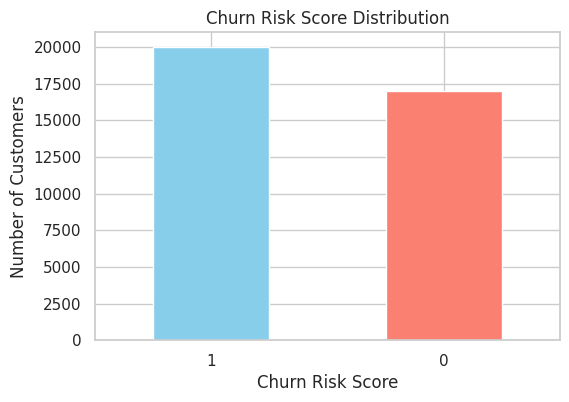

In [177]:
plt.figure(figsize=(6,4))
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Churn Risk Score Distribution')
plt.xlabel('Churn Risk Score')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)

Data Preprocessing

In [178]:
df = df.drop(columns=['security_no', 'referral_id', 'joining_date',
                      'last_visit_time', 'feedback', 'complaint_status',
                      'past_complaint', 'days_since_last_login'])

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           36992 non-null  int64  
 1   gender                        36992 non-null  object 
 2   region_category               31564 non-null  object 
 3   membership_category           36992 non-null  object 
 4   joined_through_referral       36992 non-null  object 
 5   preferred_offer_types         36704 non-null  object 
 6   medium_of_operation           36992 non-null  object 
 7   internet_option               36992 non-null  object 
 8   avg_time_spent                36992 non-null  float64
 9   avg_transaction_value         36992 non-null  float64
 10  avg_frequency_login_days      36992 non-null  object 
 11  points_in_wallet              33549 non-null  float64
 12  used_special_discount         36992 non-null  object 
 13  o

In [180]:
df.isnull().sum()

,0
age,0
gender,0
region_category,5428
membership_category,0
joined_through_referral,0
preferred_offer_types,288
medium_of_operation,0
internet_option,0
avg_time_spent,0
avg_transaction_value,0


In [181]:
df = df.dropna(subset=['preferred_offer_types']).copy()

In [182]:
df.reset_index(drop=True, inplace=True)

In [183]:
df['region_category'] = df['region_category'].fillna('Unknown')

In [184]:
df['region_category'].value_counts()

,count
region_category,
Town,14025
City,12635
Unknown,5379
Village,4665


In [185]:
df['points_wallet_missing'] = df['points_in_wallet'].isna().astype(int)
df['points_wallet_missing'].value_counts()

,count
points_wallet_missing,
0,33288
1,3416


In [186]:
wallet_median = df['points_in_wallet'].median()
df['points_in_wallet'] = df['points_in_wallet'].fillna(wallet_median)

In [187]:
df[['points_in_wallet', 'points_wallet_missing']].head()

,points_in_wallet,points_wallet_missing
0,781.750,0
1,697.665,1
2,500.690,0
3,567.660,0
4,663.060,0


In [188]:
df.isnull().sum()

,0
age,0
gender,0
region_category,0
membership_category,0
joined_through_referral,0
preferred_offer_types,0
medium_of_operation,0
internet_option,0
avg_time_spent,0
avg_transaction_value,0


In [189]:
df['joined_through_referral'].value_counts()

,count
joined_through_referral,
No,15731
Yes,15578
?,5395


In [190]:
df['joined_through_referral'] = df['joined_through_referral'].replace('?', 'Missing')

In [191]:
df['joined_through_referral'].value_counts()

,count
joined_through_referral,
No,15731
Yes,15578
Missing,5395


In [192]:
df.groupby('joined_through_referral')['churn_risk_score'].mean()

,churn_risk_score
joined_through_referral,
Missing,0.548656
No,0.521963
Yes,0.557453


In [193]:
df

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,churn_risk_score,points_wallet_missing
0,18,F,Village,Platinum Membership,No,Gift Vouchers/Coupons,?,Wi-Fi,300.630000,53005.25,17,781.750000,Yes,Yes,0,0
1,32,F,City,Premium Membership,Missing,Gift Vouchers/Coupons,Desktop,Mobile_Data,306.340000,12838.38,10,697.665000,Yes,No,0,1
2,44,F,Town,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,516.160000,21027.00,22,500.690000,No,Yes,1,0
3,37,M,City,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,53.270000,25239.56,6,567.660000,No,Yes,1,0
4,31,F,City,No Membership,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,113.130000,24483.66,16,663.060000,No,Yes,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36699,46,F,Unknown,Basic Membership,No,Credit/Debit Card Offers,Desktop,Wi-Fi,-650.682758,27277.68,6,639.510000,No,Yes,1,0
36700,29,F,Town,Basic Membership,No,Without Offers,Smartphone,Wi-Fi,-638.123421,11069.71,28,527.990000,Yes,No,1,0
36701,23,F,Unknown,Basic Membership,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,154.940000,38127.56,Error,680.470000,No,Yes,1,0
36702,53,M,Village,Platinum Membership,No,Gift Vouchers/Coupons,Smartphone,Mobile_Data,482.610000,2378.86,20,197.264414,Yes,Yes,0,0


In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36704 entries, 0 to 36703
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           36704 non-null  int64  
 1   gender                        36704 non-null  object 
 2   region_category               36704 non-null  object 
 3   membership_category           36704 non-null  object 
 4   joined_through_referral       36704 non-null  object 
 5   preferred_offer_types         36704 non-null  object 
 6   medium_of_operation           36704 non-null  object 
 7   internet_option               36704 non-null  object 
 8   avg_time_spent                36704 non-null  float64
 9   avg_transaction_value         36704 non-null  float64
 10  avg_frequency_login_days      36704 non-null  object 
 11  points_in_wallet              36704 non-null  float64
 12  used_special_discount         36704 non-null  object 
 13  o

In [195]:
df['avg_frequency_login_days'] = pd.to_numeric(df['avg_frequency_login_days'], errors='coerce').fillna(0).astype(int)

EDA and Feature Engineering

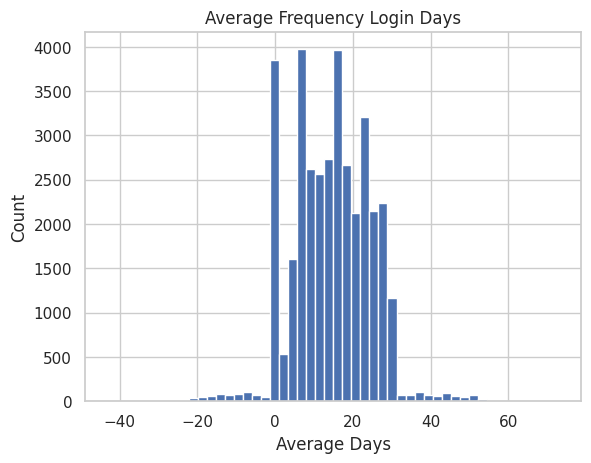

In [196]:
plt.figure()
df['avg_frequency_login_days'].hist(bins=50)
plt.title("Average Frequency Login Days")
plt.xlabel("Average Days")
plt.ylabel("Count")
plt.show()

In [28]:
df['avg_frequency_login_days'] = df['avg_frequency_login_days'].clip(lower=0)

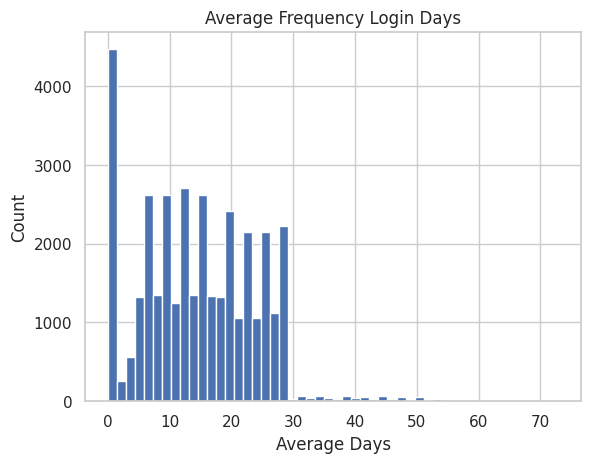

In [171]:
plt.figure()
df['avg_frequency_login_days'].hist(bins=50)
plt.title("Average Frequency Login Days")
plt.xlabel("Average Days")
plt.ylabel("Count")
plt.show()

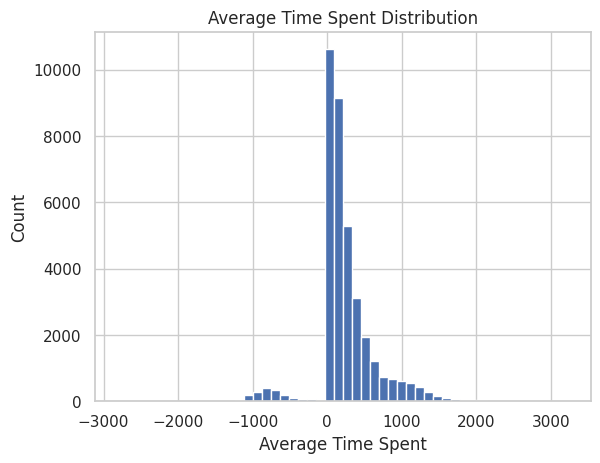

In [30]:
plt.figure()
df['avg_time_spent'].hist(bins=50)
plt.title("Average Time Spent Distribution")
plt.xlabel("Average Time Spent")
plt.ylabel("Count")
plt.show()

In [31]:
df['avg_time_spent'] = df['avg_time_spent'].clip(lower=0)

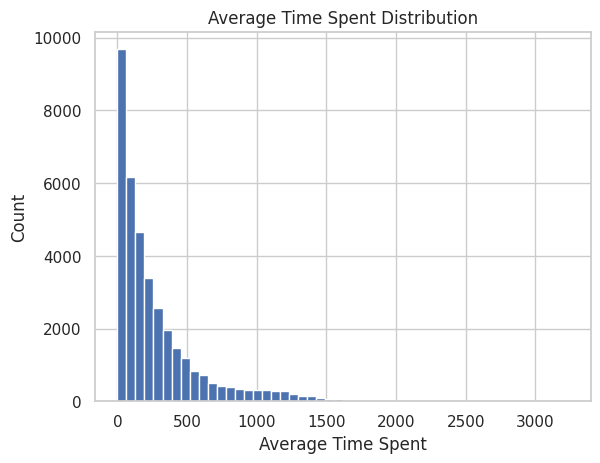

In [32]:
plt.figure()
df['avg_time_spent'].hist(bins=50)
plt.title("Average Time Spent Distribution")
plt.xlabel("Average Time Spent")
plt.ylabel("Count")
plt.show()

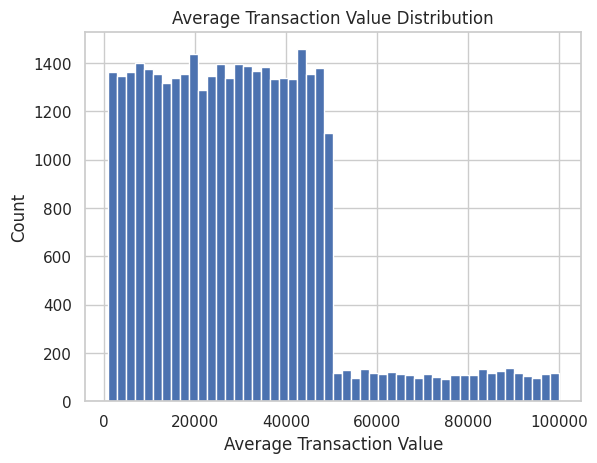

In [33]:
plt.figure()
df['avg_transaction_value'].hist(bins=50)
plt.title("Average Transaction Value Distribution")
plt.xlabel("Average Transaction Value")
plt.ylabel("Count")
plt.show()

In [34]:
df['log_avg_transaction_value'] = np.log1p(df['avg_transaction_value'])
df.drop(columns=['avg_transaction_value'], inplace=True)

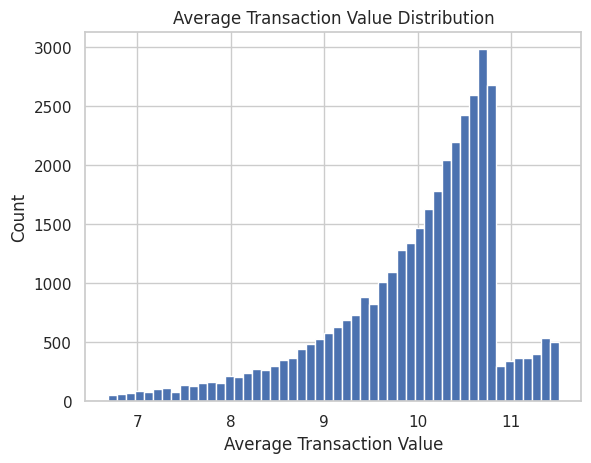

In [35]:
plt.figure()
df['log_avg_transaction_value'].hist(bins=50)
plt.title("Average Transaction Value Distribution")
plt.xlabel("Average Transaction Value")
plt.ylabel("Count")
plt.show()

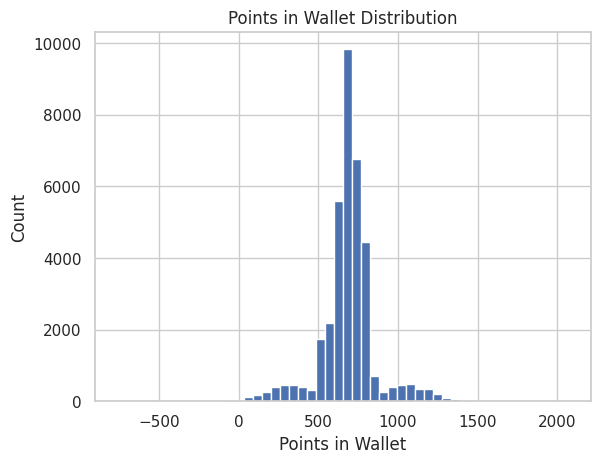

In [36]:
plt.figure()
df['points_in_wallet'].hist(bins=50)
plt.title("Points in Wallet Distribution")
plt.xlabel("Points in Wallet")
plt.ylabel("Count")
plt.show()

In [37]:
df['points_in_wallet'] = df['points_in_wallet'].clip(lower=0)

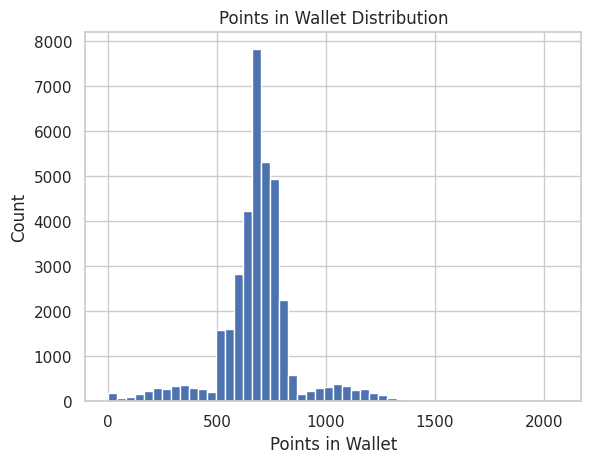

In [38]:
plt.figure()
df['points_in_wallet'].hist(bins=50)
plt.title("Points in Wallet Distribution")
plt.xlabel("Points in Wallet")
plt.ylabel("Count")
plt.show()

In [39]:
# Numerical columns
num_cols = df.drop(columns=['churn_risk_score']).select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

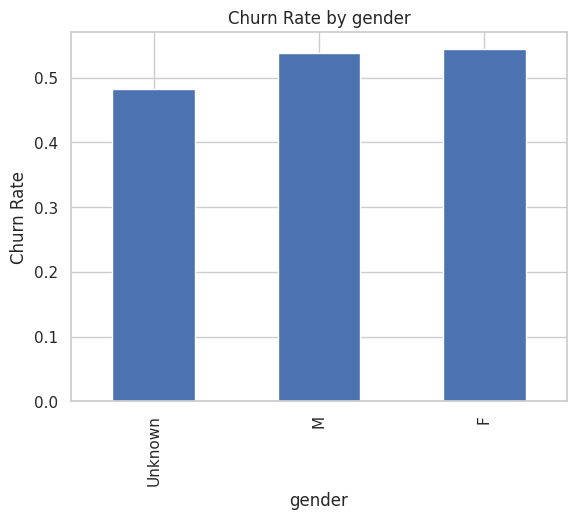

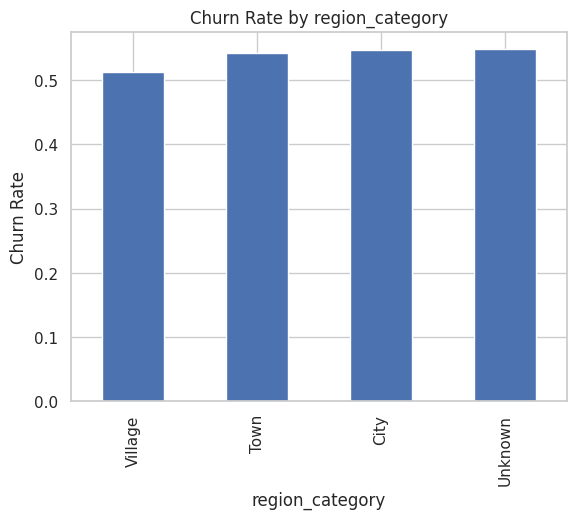

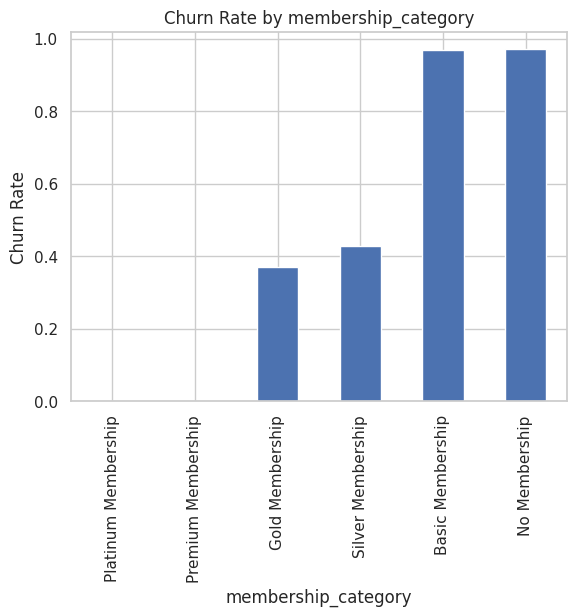

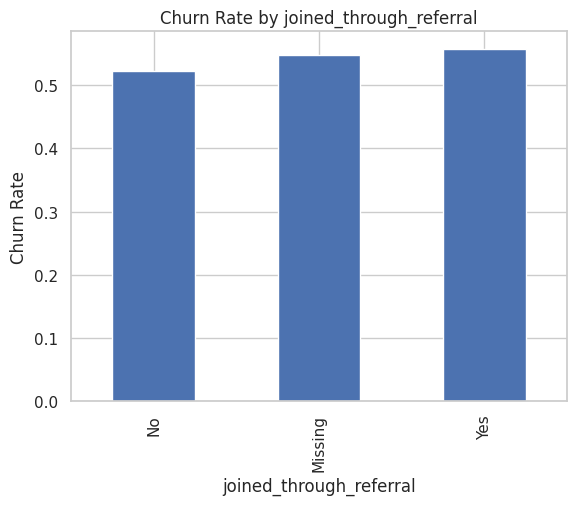

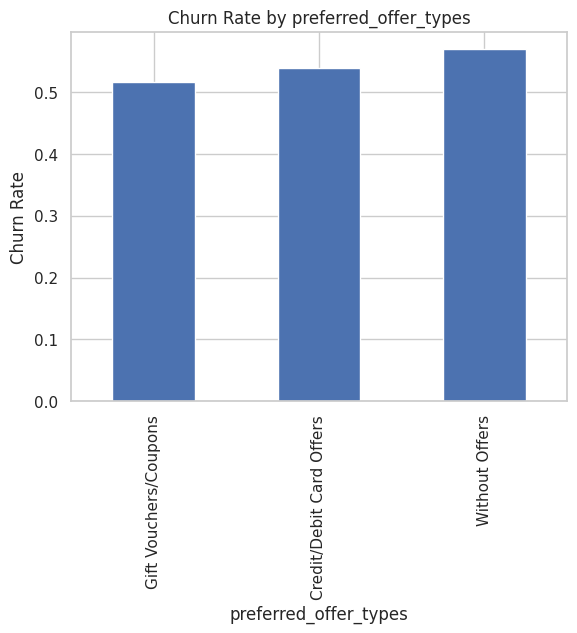

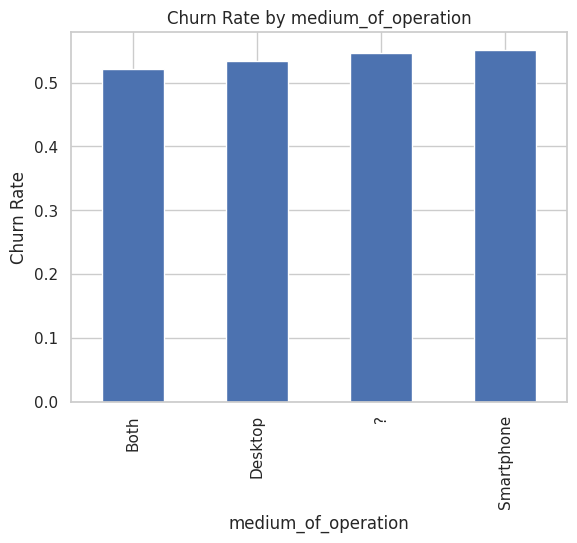

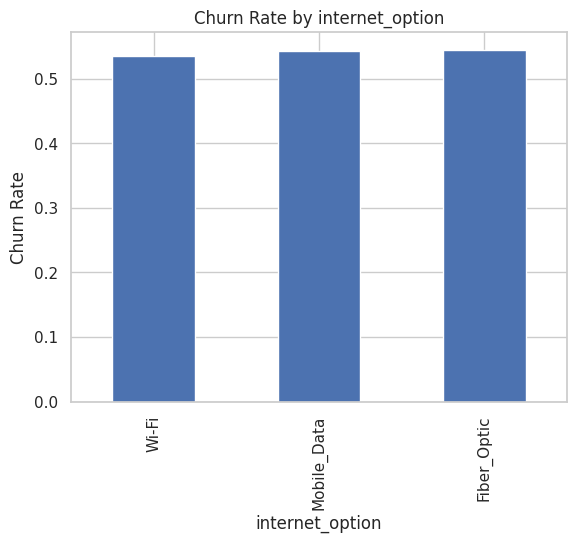

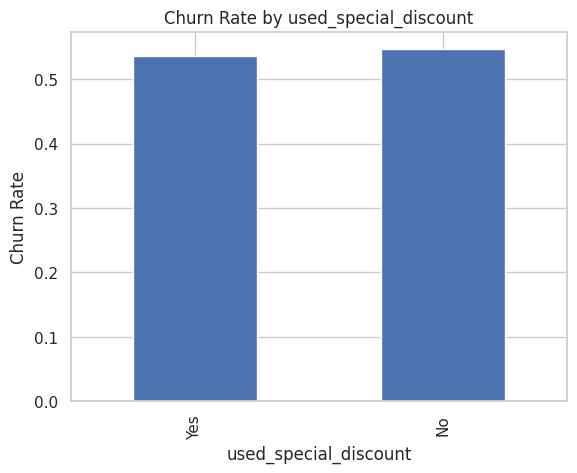

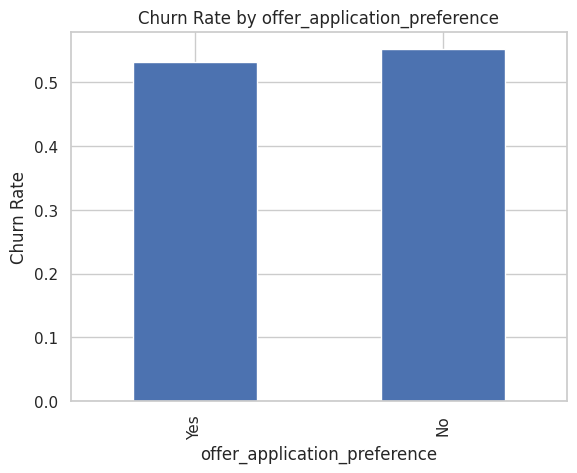

In [40]:
for col in cat_cols:
    churn_rate = df.groupby(col)['churn_risk_score'].mean().sort_values()
    plt.figure()
    churn_rate.plot(kind='bar')
    plt.title(f"Churn Rate by {col}")
    plt.xlabel(col)
    plt.ylabel("Churn Rate")
    plt.show()

In [127]:
df.to_csv('cleaned_data_customer_churn.csv', index=False)

In [128]:
files.download('cleaned_data_customer_churn.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36704 entries, 0 to 36703
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           36704 non-null  int64  
 1   gender                        36704 non-null  object 
 2   region_category               36704 non-null  object 
 3   membership_category           36704 non-null  object 
 4   joined_through_referral       36704 non-null  object 
 5   preferred_offer_types         36704 non-null  object 
 6   medium_of_operation           36704 non-null  object 
 7   internet_option               36704 non-null  object 
 8   avg_time_spent                36704 non-null  float64
 9   avg_frequency_login_days      36704 non-null  int64  
 10  points_in_wallet              36704 non-null  float64
 11  used_special_discount         36704 non-null  object 
 12  offer_application_preference  36704 non-null  object 
 13  c

Train test split

In [42]:
X = df.drop(columns=['churn_risk_score'])
y = df['churn_risk_score']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Scaling and Encoding

In [44]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

Logistic Regression

In [61]:
log_reg = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
)

In [63]:
pipeline_lr = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', log_reg)
])

In [64]:
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'avg_time_spent',
                                                   'avg_frequency_login_days',
                                                   'points_in_wallet',
                                                   'points_wallet_missing',
                                                   'log_avg_transaction_value']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'region_category',
                                                   'membership_category',
                                                   'joined_through_referral',
                                                   'preferred_offer_types',
                                                   'medium_of_operation',
                                                   'internet_option',
                                                   'used_special_discount',
                                                   'offer_application_preference'])])),
                ('model', LogisticRegression(max_iter=1000))])

In [116]:
y_train_pred = pipeline_lr.predict(X_train)
y_test_pred = pipeline_lr.predict(X_test)

y_test_proba = pipeline_lr.predict_proba(X_test)[:, 1]

In [117]:
print("TRAIN REPORT")
print(classification_report(y_train, y_train_pred))

print("TEST REPORT")
print(classification_report(y_test, y_test_pred))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.80      0.93      0.86     13479
           1       0.93      0.80      0.86     15884

    accuracy                           0.86     29363
   macro avg       0.86      0.86      0.86     29363
weighted avg       0.87      0.86      0.86     29363

TEST REPORT
              precision    recall  f1-score   support

           0       0.80      0.94      0.86      3370
           1       0.94      0.81      0.87      3971

    accuracy                           0.87      7341
   macro avg       0.87      0.87      0.87      7341
weighted avg       0.88      0.87      0.87      7341



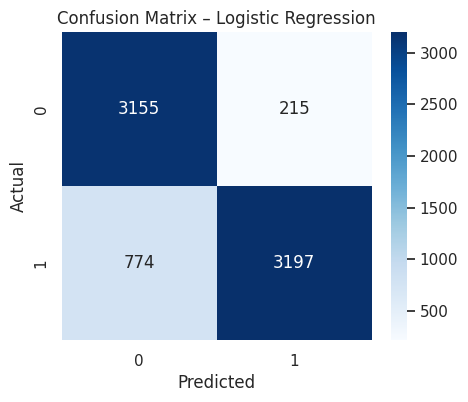

In [118]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

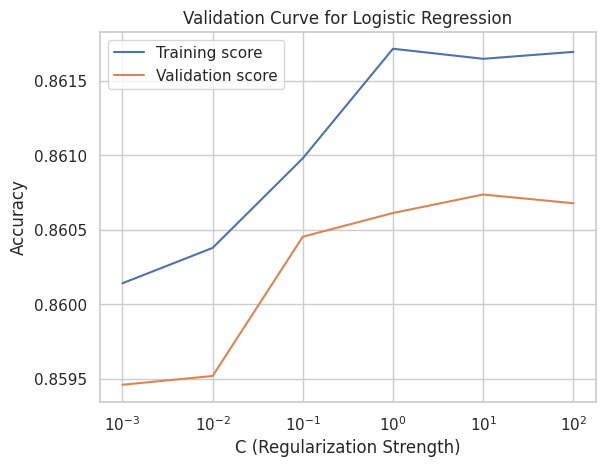

In [119]:
param_range = [0.001, 0.01, 0.1, 1, 10, 100]

train_scores, val_scores = validation_curve(
    pipeline_lr,
    X_train,
    y_train,
    param_name='model__C',
    param_range=param_range,
    cv=5,
    scoring='f1',
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure()
plt.semilogx(param_range, train_mean, label='Training score')
plt.semilogx(param_range, val_mean, label='Validation score')
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for Logistic Regression')
plt.legend()
plt.show()

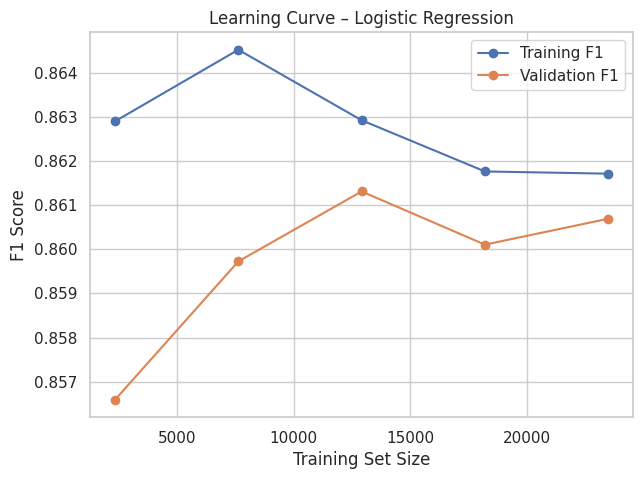

In [120]:
train_sizes, train_scores, val_scores = learning_curve(
    pipeline_lr,
    X_train,
    y_train,
    cv=5,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker='o', label='Training F1')
plt.plot(train_sizes, val_mean, marker='o', label='Validation F1')
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.title("Learning Curve – Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

In [141]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    pipeline_lr,
    X_train,
    y_train,
    cv=skf,
    scoring='f1'
)

print("CV F1 scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())

CV F1 scores: [0.8650461  0.85255326 0.85931431 0.86174178 0.86288971]
Mean CV F1: 0.860309032303171


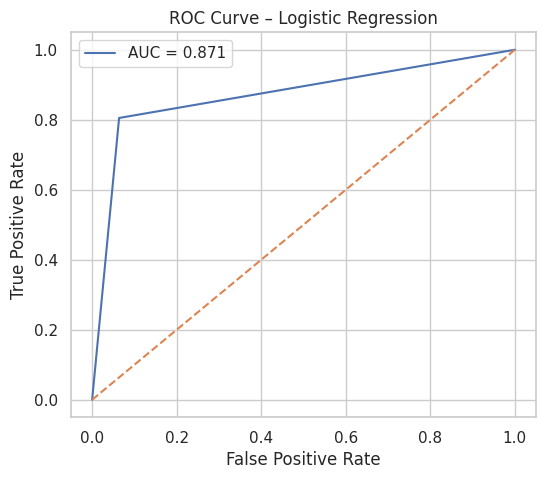

In [122]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.show()

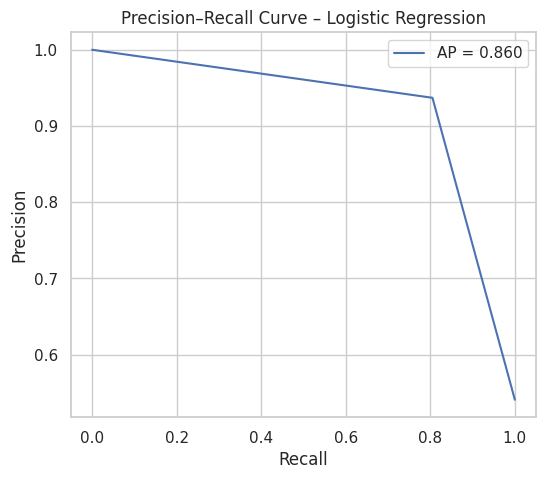

In [123]:
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
ap = average_precision_score(y_test, y_test_pred)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Logistic Regression")
plt.legend()
plt.show()

HyperParameter Tuning

In [68]:
param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear'],
    'model__class_weight': [None, 'balanced']
}


grid_search = GridSearchCV(
    estimator=pipeline_lr,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

Best parameters: {'model__C': 0.001, 'model__class_weight': None, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best CV score: 0.9103696025467777


In [ ]:
best_pipeline_lr = grid_search.best_estimator_

y_train_pred = best_pipeline_lr.predict(X_train)
y_test_pred = best_pipeline_lr.predict(X_test)

print("Tuned Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Tuned Test Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Tuned Train Accuracy: 0.9123046010285053
Tuned Test Accuracy: 0.9179948235935159
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      3370
           1       0.93      0.92      0.92      3971

    accuracy                           0.92      7341
   macro avg       0.92      0.92      0.92      7341
weighted avg       0.92      0.92      0.92      7341



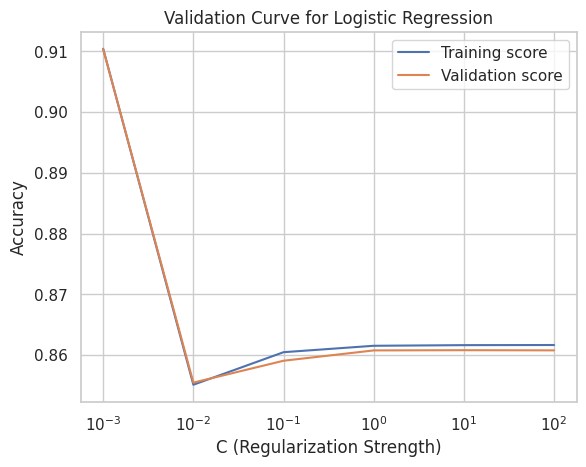

In [70]:
param_range = [0.001, 0.01, 0.1, 1, 10, 100]

train_scores, val_scores = validation_curve(
    best_pipeline_lr,
    X_train,
    y_train,
    param_name='model__C',
    param_range=param_range,
    cv=5,
    scoring='f1',
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure()
plt.semilogx(param_range, train_mean, label='Training score')
plt.semilogx(param_range, val_mean, label='Validation score')
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for Logistic Regression')
plt.legend()
plt.show()

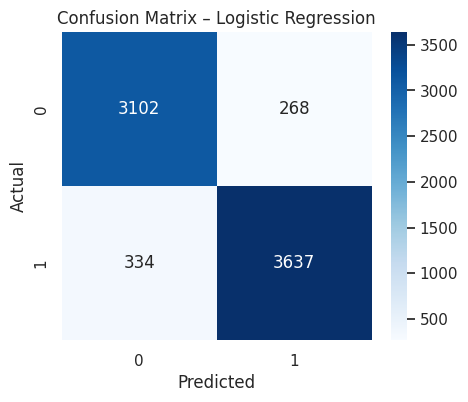

In [55]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

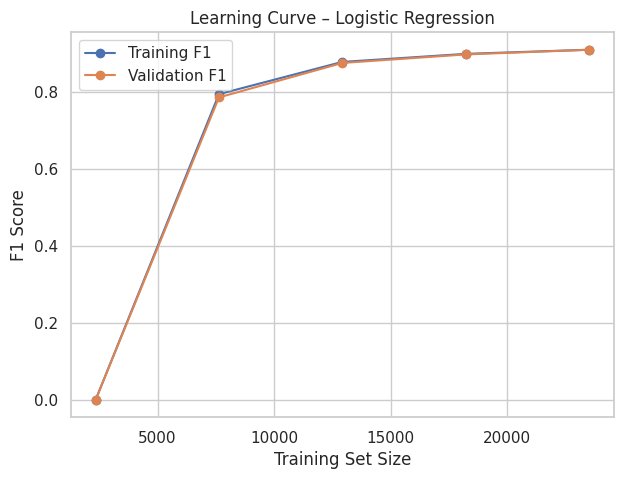

In [56]:
train_sizes, train_scores, val_scores = learning_curve(
    best_pipeline_lr,
    X_train,
    y_train,
    cv=5,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker='o', label='Training F1')
plt.plot(train_sizes, val_mean, marker='o', label='Validation F1')
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.title("Learning Curve – Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

In [71]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    best_pipeline_lr,
    X_train,
    y_train,
    cv=skf,
    scoring='f1'
)

print("CV F1 scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())

CV F1 scores: [0.91570457 0.90602103 0.91391152 0.90532356 0.91092862]
Mean CV F1: 0.9103778572483648


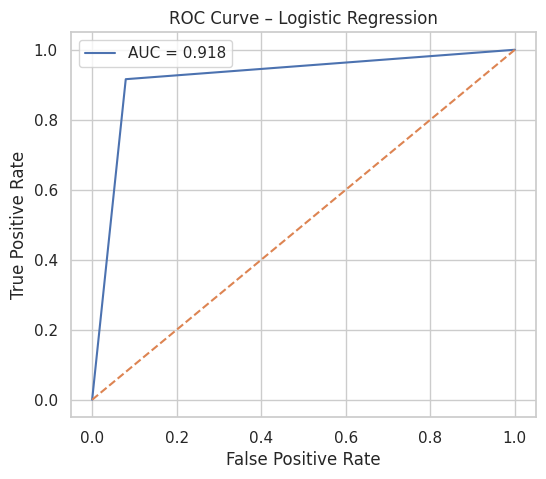

In [58]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.show()

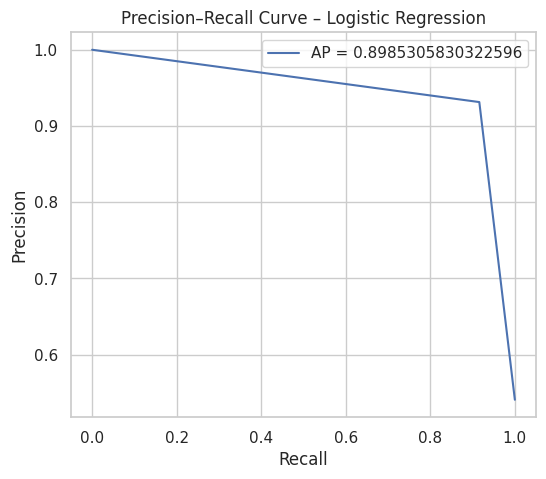

In [60]:
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
ap = average_precision_score(y_test, y_test_pred)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Logistic Regression")
plt.legend()
plt.show()

Random Forest

In [73]:
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

In [74]:
rf_baseline = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

In [75]:
pipeline_rf = Pipeline(steps=[
    ('preprocess', preprocessor_rf),
    ('model', rf_baseline)
])

In [76]:
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'avg_time_spent',
                                                   'avg_frequency_login_days',
                                                   'points_in_wallet',
                                                   'points_wallet_missing',
                                                   'log_avg_transaction_value']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'region_category',
                                                   'membership_category',
                                                   'joined_through_referral',
                                                   'preferred_offer_types',
                                                   'medium_of_operation',
                                                   'internet_option',
                                                   'used_special_discount',
                                                   'offer_application_preference'])])),
                ('model', RandomForestClassifier(n_jobs=-1, random_state=42))])

In [142]:
y_train_pred = pipeline_rf.predict(X_train)
y_test_pred = pipeline_rf.predict(X_test)

y_test_proba = pipeline_rf.predict_proba(X_test)[:, 1]

In [144]:
from sklearn.metrics import classification_report

print("TRAIN REPORT – RANDOM FOREST")
print(classification_report(y_train, y_train_pred))

print("TEST REPORT – RANDOM FOREST")
print(classification_report(y_test, y_test_pred))

TRAIN REPORT – RANDOM FOREST
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13479
           1       1.00      1.00      1.00     15884

    accuracy                           1.00     29363
   macro avg       1.00      1.00      1.00     29363
weighted avg       1.00      1.00      1.00     29363

TEST REPORT – RANDOM FOREST
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      3370
           1       0.94      0.93      0.94      3971

    accuracy                           0.93      7341
   macro avg       0.93      0.93      0.93      7341
weighted avg       0.93      0.93      0.93      7341



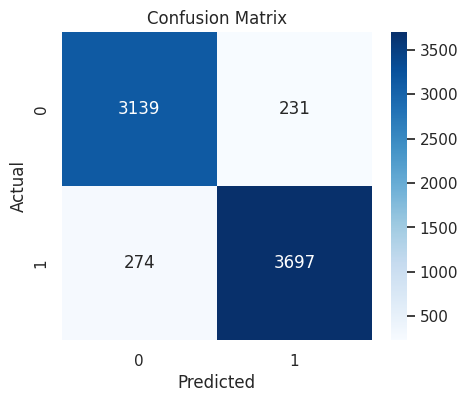

In [145]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [146]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    pipeline_rf,
    X_train,
    y_train,
    cv=skf,
    scoring='f1',
    n_jobs=-1
)

print("CV F1 scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())

CV F1 scores: [0.93469709 0.92878668 0.93426485 0.92912884 0.9343227 ]
Mean CV F1: 0.9322400314350425


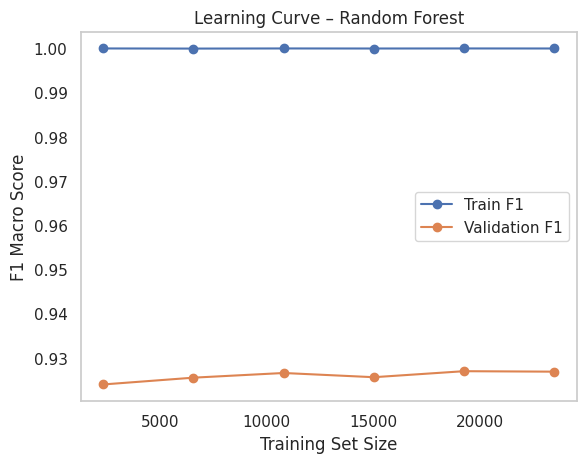

In [147]:
from sklearn.model_selection import learning_curve
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes = np.linspace(0.1, 1.0, 6)

train_sizes_rf, train_scores_rf, val_scores_rf = learning_curve(
    estimator=pipeline_rf,
    X=X_train,
    y=y_train,
    train_sizes=train_sizes,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1
)

train_mean_rf = np.mean(train_scores_rf, axis=1)
val_mean_rf = np.mean(val_scores_rf, axis=1)

plt.figure()
plt.plot(train_sizes_rf, train_mean_rf, marker='o', label='Train F1')
plt.plot(train_sizes_rf, val_mean_rf, marker='o', label='Validation F1')
plt.xlabel("Training Set Size")
plt.ylabel("F1 Macro Score")
plt.title("Learning Curve – Random Forest")
plt.legend()
plt.grid()
plt.show()

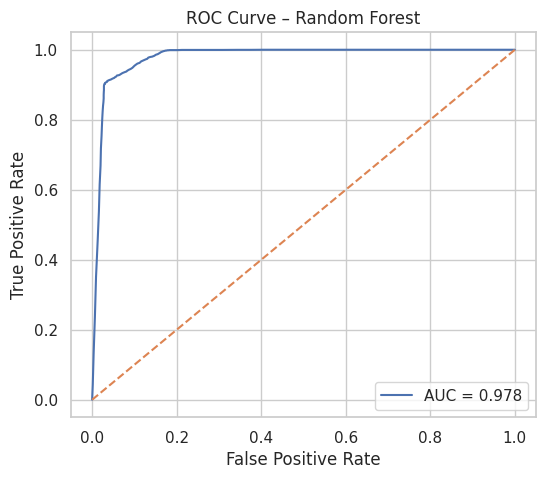

In [148]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest")
plt.legend()
plt.show()

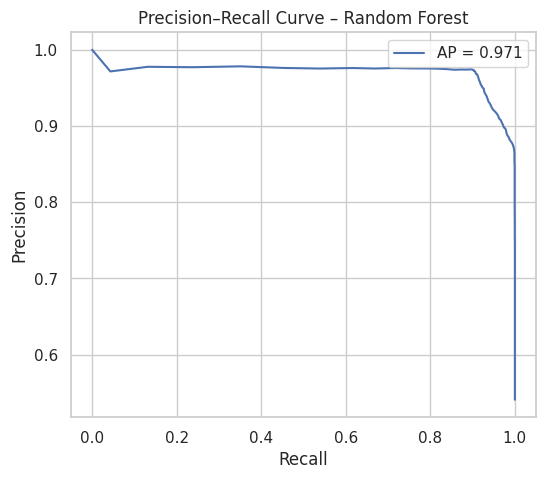

In [149]:
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
ap = average_precision_score(y_test, y_test_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Random Forest")
plt.legend()
plt.show()

In [150]:
from sklearn.model_selection import RandomizedSearchCV
param_dist_rf = {
    'model__n_estimators': [150, 200, 250],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', 'log2'],
    'model__class_weight': [None, 'balanced']
}

random_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_dist_rf,
    n_iter=20,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
random_rf.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               'passthrough',
                                                                               ['age',
                                                                                'avg_time_spent',
                                                                                'avg_frequency_login_days',
                                                                                'points_in_wallet',
                                                                                'points_wallet_missing',
                                                                                'log_avg_transaction_value']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['gender',
                                                                                'region_category',
                                                                                'membership_category',
                                                                                'joined_throu...
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__class_weight': [None,
                                                                'balanced'],
                                        'model__max_depth': [None, 10, 20],
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_leaf': [1, 2],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [150, 200, 250]},
                   random_state=42, scoring='f1_macro', verbose=1)

In [151]:
best_pipeline_rf = random_rf.best_estimator_

y_train_pred_rf = best_pipeline_rf.predict(X_train)
y_test_pred_rf = best_pipeline_rf.predict(X_test)

print("RF – Tuned Train Accuracy:", accuracy_score(y_train, y_train_pred_rf))
print("RF – Tuned Test Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("RF – Classification Report:\n", classification_report(y_test, y_test_pred_rf))

RF – Tuned Train Accuracy: 0.9818138473589211
RF – Tuned Test Accuracy: 0.9317531671434409
RF – Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      3370
           1       0.95      0.93      0.94      3971

    accuracy                           0.93      7341
   macro avg       0.93      0.93      0.93      7341
weighted avg       0.93      0.93      0.93      7341



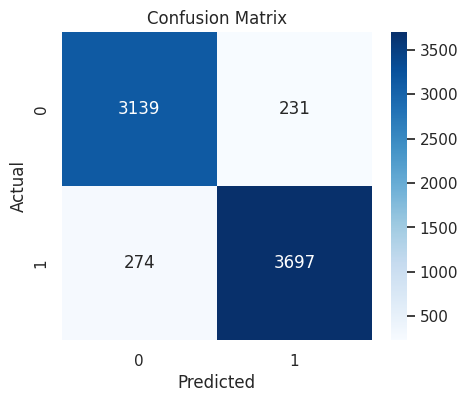

In [152]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [153]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    best_pipeline_rf,
    X_train,
    y_train,
    cv=skf,
    scoring='f1',
    n_jobs=-1
)

print("CV F1 scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())

CV F1 scores: [0.93822881 0.9286282  0.93369461 0.93058221 0.93367185]
Mean CV F1: 0.9329611362292898


In [154]:
from sklearn.model_selection import learning_curve
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes = np.linspace(0.1, 1.0, 6)

train_sizes_rf, train_scores_rf, val_scores_rf = learning_curve(
    estimator=best_pipeline_rf,
    X=X_train,
    y=y_train,
    train_sizes=train_sizes,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1
)

train_mean_rf = np.mean(train_scores_rf, axis=1)
val_mean_rf = np.mean(val_scores_rf, axis=1)

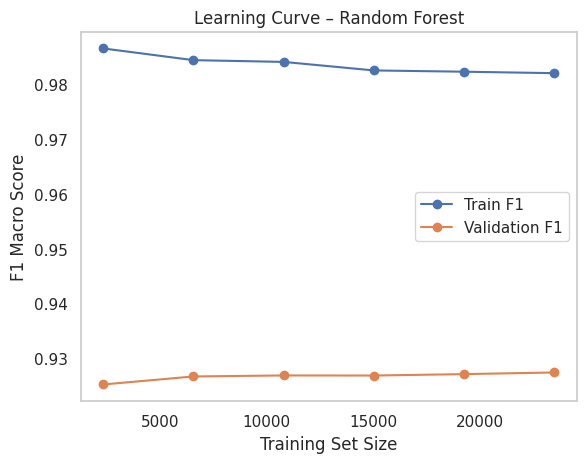

In [155]:
plt.figure()
plt.plot(train_sizes_rf, train_mean_rf, marker='o', label='Train F1')
plt.plot(train_sizes_rf, val_mean_rf, marker='o', label='Validation F1')
plt.xlabel("Training Set Size")
plt.ylabel("F1 Macro Score")
plt.title("Learning Curve – Random Forest")
plt.legend()
plt.grid()
plt.show()

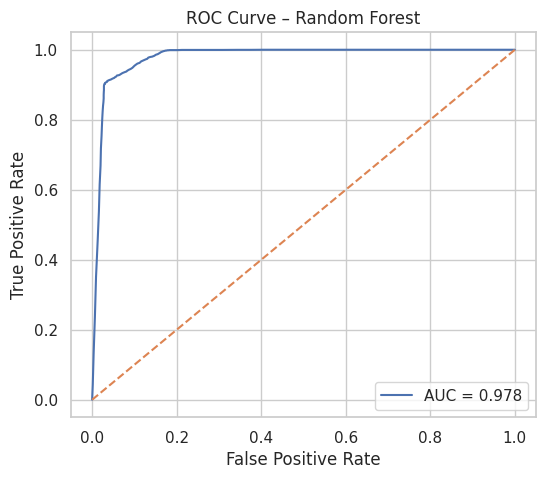

In [156]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest")
plt.legend()
plt.show()

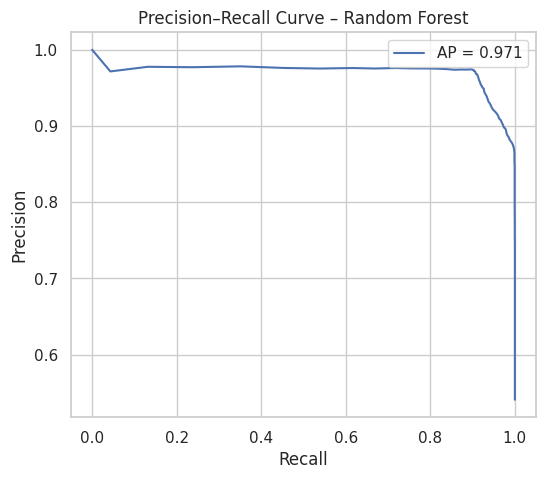

In [157]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
ap = average_precision_score(y_test, y_test_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Random Forest")
plt.legend()
plt.show()

XGBOOST

In [158]:
preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

In [159]:
xgb_baseline = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    n_jobs=-1
)

In [160]:
pipeline_xgb = Pipeline(steps=[
    ('preprocess', preprocessor_xgb),
    ('model', xgb_baseline)
])

In [161]:
pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'avg_time_spent',
                                                   'avg_frequency_login_days',
                                                   'points_in_wallet',
                                                   'points_wallet_missing',
                                                   'log_avg_transaction_value']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'region_category',
                                                   'membership_category',
                                                   'joined_through_referral',
                                                   'preferred_offer_type...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [162]:
y_train_pred = pipeline_xgb.predict(X_train)
y_test_pred = pipeline_xgb.predict(X_test)

y_test_proba = pipeline_xgb.predict_proba(X_test)[:, 1]

In [163]:
print("TRAIN REPORT – XGBOOST")
print(classification_report(y_train, y_train_pred))

print("TEST REPORT – XGBOOST")
print(classification_report(y_test, y_test_pred))

TRAIN REPORT – XGBOOST
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     13479
           1       0.95      0.94      0.95     15884

    accuracy                           0.94     29363
   macro avg       0.94      0.94      0.94     29363
weighted avg       0.94      0.94      0.94     29363

TEST REPORT – XGBOOST
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3370
           1       0.95      0.93      0.94      3971

    accuracy                           0.94      7341
   macro avg       0.94      0.94      0.94      7341
weighted avg       0.94      0.94      0.94      7341



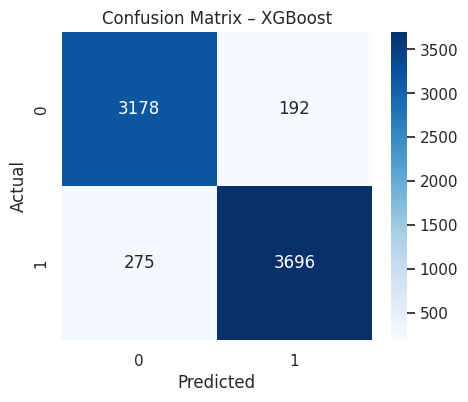

In [165]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – XGBoost")
plt.show()

In [166]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    pipeline_xgb,
    X_train,
    y_train,
    cv=skf,
    scoring='f1',
    n_jobs=-1
)

print("CV F1 scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())

CV F1 scores: [0.94003499 0.93422948 0.93995529 0.9359242  0.94044586]
Mean CV F1: 0.9381179632684651


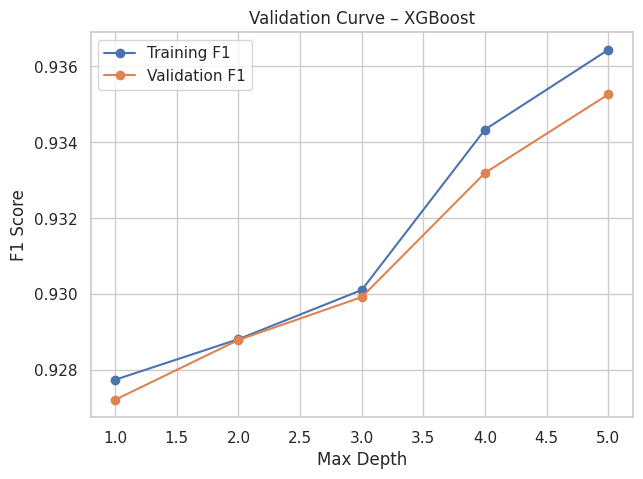

In [135]:
param_range = [1, 2, 3, 4, 5]

train_scores, val_scores = validation_curve(
    pipeline_xgb,
    X_train,
    y_train,
    param_name="model__max_depth",
    param_range=param_range,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(7,5))
plt.plot(param_range, train_mean, marker='o', label='Training F1')
plt.plot(param_range, val_mean, marker='o', label='Validation F1')
plt.xlabel("Max Depth")
plt.ylabel("F1 Score")
plt.title("Validation Curve – XGBoost")
plt.legend()
plt.grid(True)
plt.show()

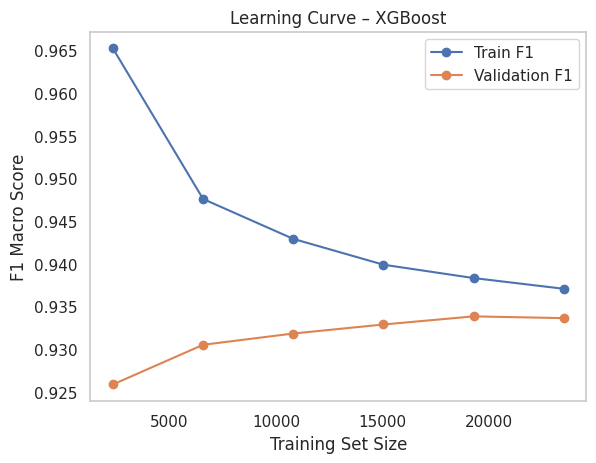

In [136]:
train_sizes_xgb, train_scores_xgb, val_scores_xgb = learning_curve(
    estimator=pipeline_xgb,
    X=X_train,
    y=y_train,
    train_sizes=train_sizes,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1
)

train_mean_xgb = np.mean(train_scores_xgb, axis=1)
val_mean_xgb = np.mean(val_scores_xgb, axis=1)

plt.figure()
plt.plot(train_sizes_xgb, train_mean_xgb, marker='o', label='Train F1')
plt.plot(train_sizes_xgb, val_mean_xgb, marker='o', label='Validation F1')
plt.xlabel("Training Set Size")
plt.ylabel("F1 Macro Score")
plt.title("Learning Curve – XGBoost")
plt.legend()
plt.grid()
plt.show()

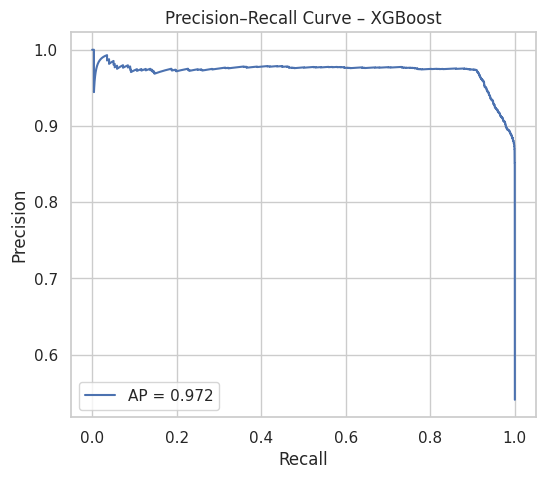

In [167]:
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
ap = average_precision_score(y_test, y_test_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – XGBoost")
plt.legend()
plt.show()

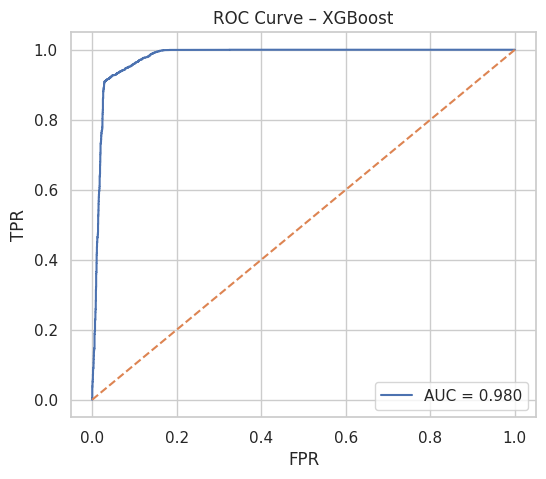

In [168]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve – XGBoost")
plt.legend()
plt.show()